# Comparison between different Portfolio Optimization Stragegies

**Author : Han Chu**

This project is designed to visualize the Mean-variance portfolio optimization and compare performances of different strategies. The data are stock prices of 5 real Chinese listed companies, I downloaded from Wind Database, period is from 2019 to 2023. Inside the Mean-variance strategy, I simulated 1000 possible random portfolios to draw scatters, then the efficient frontier and the Global Minimum Variance, the Maximum Sharpe Ratio (the Optimal portfolio). In the app, you will see the correlation matrix, interactive slidebars which allow different returns and volatilities, tables and diagrams of Returns and Volatilities of different portfolio strategies. After applying strategies, you can download the Excel file to check the weight distribution of the portfolios you chose.


## Definitions

In [6]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datas import app_dir, data  # data is here
import seaborn as sns
from shiny import App, Inputs, Outputs, Session, render, ui, reactive
import os
# Global configuration

risk_free = 0.02        # Approximately 10-year Chinese government bond yield 0.02
initial_amount = 10000  # Initial investment
code_list = ["600897", "300750", "601857", "300015", "601088"]
for code in code_list:
    print(code)


# 1. Data Preprocessing & Annualized Covariance
daily_return = pd.pivot_table(data, index="date", columns="code", values="return")
daily_return = daily_return / 100.0
market_size = pd.pivot_table(data, index="date", columns="code", values="marketcap")
market_size = market_size.bfill()
daily_return.index = pd.to_datetime(daily_return.index)

# Split into training set (for estimating returns/covariance) and test set (for validation/actual portfolio returns)
train = daily_return[daily_return.index < "2020-01-01"]
test_daily_return = daily_return[daily_return.index >= "2020-01-01"]

market_size.index = pd.to_datetime(market_size.index)
market_size = market_size[market_size.index >= "2020-01-01"]

stock_return = train
cov_mat = stock_return.cov()
cov_mat_annual = cov_mat * 252

600897
300750
601857
300015
601088


## Equal Weight and Market value weighted porfolio


First we start with Equal Weight and Market value weighted porfolio

---
**Equal Weight Portfolio**

An Equal Weight Portfolio assigns the same weight to each asset regardless of its market value. For a portfolio with $ n $ assets, each asset's weight is:

$$
w_i = \frac{1}{n}, \quad \text{for } i = 1, 2, \dots, n.
$$

The portfolio return then is:

$$
E(R_{\text{Equal}}) = \frac{1}{n}\sum_{i=1}^{n} E(r_i)
$$

and the portfolio risk (variance) is computed as:

$$
\sigma_{\text{Equal}}^2 = \frac{1}{n^2}\left( \sum_{i=1}^{n} \sigma_i^2 + \sum_{i=1}^{n}\sum_{\substack{j=1 \\ j \neq i}}^{n} \mathrm{Cov}_{ij} \right).
$$

Taking the square root gives the portfolio's standard deviation:

$$
\sigma_{\text{Equal}} = \sqrt{ \frac{1}{n^2}\left( \sum_{i=1}^{n} \sigma_i^2 + \sum_{i=1}^{n}\sum_{\substack{j=1 \\ j \neq i}}^{n} \mathrm{Cov}_{ij} \right) }.
$$


*Note:* The calculation of the portfolio risk for an equal weight portfolio follows the same variance formula as above with $ w_i = \frac{1}{n} $.

Also, very interesting fact that **Harry Markowitz**, in an interview late in life about his pension portfolio, responded, "**I thought, 'You know, if the stock market goes way up and I'm not in, I'll feel stupid. And if it goes way down and I'm in it, I'll feel stupid.' So I went 50-50.**" So he applied this **Equal weight stratege!**
(URL: https://www.stockopedia.com/content/value-investing-fact-and-fiction-does-cheap-beat-expensive-97647/)

---
**Market Value Weighted Portfolio**

In a Market Value Weighted Portfolio, each asset's weight is proportional to its market capitalization. Suppose $ M_i $ denotes the market value (capitalization) of asset $ i $. The weight $ w_i $ is given by:

$$
w_i = \frac{M_i}{\sum_{j=1}^{n} M_j}
$$

Thus, the portfolio return is calculated as:

$$
E(R_{MV}) = \sum_{i=1}^{n} w_i\,E(r_i)
$$

and its risk (standard deviation) is computed using the standard portfolio variance formula:

$$
\sigma_{MV} = \sqrt{ \sum_{i=1}^{n} w_i^2\,\sigma_i^2 + \sum_{i=1}^{n} \sum_{j=i+1}^{n} w_i\,w_j\,\mathrm{Cov}_{ij} }.
$$


In [9]:
# 2. Market Cap Weighted & Equal Weighted

def normalize_row(row):
    return row / row.sum()

market_size_norm = market_size.apply(normalize_row, axis=1)
mv_weight = test_daily_return.mul(market_size_norm, axis=1).sum(axis=1)

StockReturns = pd.DataFrame(mv_weight, columns=["marketcap weighted"])
StockReturns["equal weight"] = test_daily_return.mean(axis=1).values

StockReturns["equal weight"]

date
2020-01-02    0.00672
2020-01-03    0.00454
2020-01-06    0.00926
2020-01-07   -0.00042
2020-01-08   -0.00216
               ...   
2023-12-25    0.00006
2023-12-26   -0.00664
2023-12-27    0.00848
2023-12-28    0.02204
2023-12-29   -0.00340
Name: equal weight, Length: 970, dtype: float64

In [11]:
StockReturns["marketcap weighted"]

date
2020-01-02    0.009069
2020-01-03    0.010113
2020-01-06    0.028215
2020-01-07   -0.010564
2020-01-08    0.007393
                ...   
2023-12-25    0.009199
2023-12-26   -0.001308
2023-12-27    0.009199
2023-12-28    0.010227
2023-12-29    0.000132
Name: marketcap weighted, Length: 970, dtype: float64

## Maximum Variance Portfolio




In the context of portfolio optimization, the **Maximum Variance Portfolio** is the portfolio that has the highest possible variance (risk) among all feasible portfolios. Given a vector of asset weights $w = (w_1, w_2, \dots, w_n)^T$ and the covariance matrix of asset returns $ Sigma$, the portfolio variance is defined as:

$$
\sigma_p^2 = w^T \Sigma w
$$

The Maximum Variance Portfolio is obtained by solving the following optimization problem:

$$
\begin{aligned}
\max_{w} \quad & w^T \Sigma w \\
\text{subject to} \quad & \sum_{i=1}^{n} w_i = 1.
\end{aligned}
$$

This formulation finds the portfolio weights that maximize the portfolio’s variance, subject to the full-investment constraint. Although such a portfolio is rarely practical due to its extreme risk, it serves as a theoretical benchmark in portfolio analysis.

---

**Minimum Variance Portfolio:**

$$
\begin{aligned}
\min_{\{\omega_i\}} \quad & \mathrm{Var}(r_p) \\
\text{subject to} \quad & \bar{r}_p = \sum_{i=1}^n \omega_i \, E(r_i), \\
& \sum_{i=1}^n \omega_i = 1.
\end{aligned}
$$

---

In [16]:
# 3. Random Portfolios & Extracting Max Variance

n = len(code_list)
number = 1000 # Number of random portfolios
random_p = np.empty((number, n + 2))  # [weights..., Returns, Volatility]
np.random.seed(123)

for i in range(number):
    w_rand = np.random.random(n)
    w_rand /= w_rand.sum()   # No short selling
    # Estimate portfolio daily return on training data
    port_ret_daily = stock_return.mul(w_rand, axis=1).sum(axis=1).mean()
    annual_ret = (1 + port_ret_daily)**252 - 1
    annual_vol = np.sqrt(np.dot(w_rand.T, np.dot(cov_mat_annual, w_rand)))
    random_p[i, :n] = w_rand
    random_p[i, n] = annual_ret
    random_p[i, n+1] = annual_vol

RandomPortfolios = pd.DataFrame(
    random_p,
    columns=[code + "_weight" for code in code_list] + ["Returns", "Volatility"]
)

# Only take portfolios with positive returns
positive_returns = RandomPortfolios[RandomPortfolios["Returns"] > 0]
if not positive_returns.empty:
   # From random portfolios, find the one with minimum volatility (for reference)
    min_positive_index = positive_returns["Volatility"].idxmin()
    # From random portfolios, find the one with maximum volatility => Max Variance
    max_positive_index = positive_returns["Volatility"].idxmax()
    MaxVar_weights = np.array(RandomPortfolios.iloc[max_positive_index, 0:n])
else:
    # If no portfolio with positive return, set equal weights
    MaxVar_weights = np.full(n, 1.0/n)

MaxVar_weights_df = pd.DataFrame({"Code": code_list, "Weight": MaxVar_weights})
# calculate the daily return of this portfolio on test dataset 在测试集上计算该组合的每日收益
StockReturns["Max Variance"] = test_daily_return.mul(MaxVar_weights, axis=1).sum(axis=1)
StockReturns["Max Variance"]

date
2020-01-02    0.002065
2020-01-03    0.000981
2020-01-06   -0.003302
2020-01-07    0.007390
2020-01-08   -0.004389
                ...   
2023-12-25   -0.016379
2023-12-26   -0.004976
2023-12-27    0.016775
2023-12-28    0.034858
2023-12-29   -0.014649
Name: Max Variance, Length: 970, dtype: float64

## Mean-variance

**The Mean-Variance (Markowitz Modern Portfolio) Theory**

In the context of portfolio selection, Maximum Variance Theory involves choosing the portfolio from the feasible set that has the largest variance (risk). While Markowitz’s classic approach usually focuses on minimizing variance or maximizing the Sharpe ratio, one can, in theory, reverse the problem to pick the portfolio with the highest variance—though this is rarely practical in real-world investing. A maximum variance portfolio typically concentrates extreme weights in the riskiest assets, resulting in very high volatility.

The Markowitz approach to portfolio optimization is commonly referred to as Mean-Variance (MV) optimization. It is based on the mean (expected return) and variance(risk) of assets within a portfolio.

**The portfolio’s return**
In Markowitz’s framework, the portfolio’s return is calculated as a weighted sum of the returns of the individual assets. That is,

$$
r_p = \sum_{i=1}^{n} w_i\,r_i
$$

where:

- $ r_p $ is the portfolio’s return,
- $ w_i $ is the weight of the $ i $-th asset in the portfolio,
- $ r_i $ is the return of the $ i $-th asset,
- $ n $ is the total number of assets.
  
If we consider the expected returns, the portfolio’s expected return is given by:

$$
E(r_p) = \sum_{i=1}^{n} w_i\,E(r_i)
$$

where:

- $ E(r_p) $ is the expected return of the portfolio,
- $ E(r_i) $ is the expected return of the $ i $-th asset.

---

**The portfolio's risk** (i.e., the standard deviation) is given by:

$$
\sigma_{\text{port}}
= \sqrt{
    \sum_{i=1}^n w_i^2 \,\sigma_i^2 
    \;+\; \sum_{i=1}^n \sum_{j=i+1}^n w_i \, w_j \,\mathrm{Cov}_{ij}
}
$$

where:

- $ \sigma_{\text{port}} $ = the standard deviation of the portfolio  
- $ w_i $ = the weight of the $i$-th asset in the portfolio  
- $ \sigma_i^2 $ = the variance of rates of return for asset $ i $  
- $ \mathrm{Cov}_{ij} $ = the covariance between rates of return for assets $ i $ and $ j $

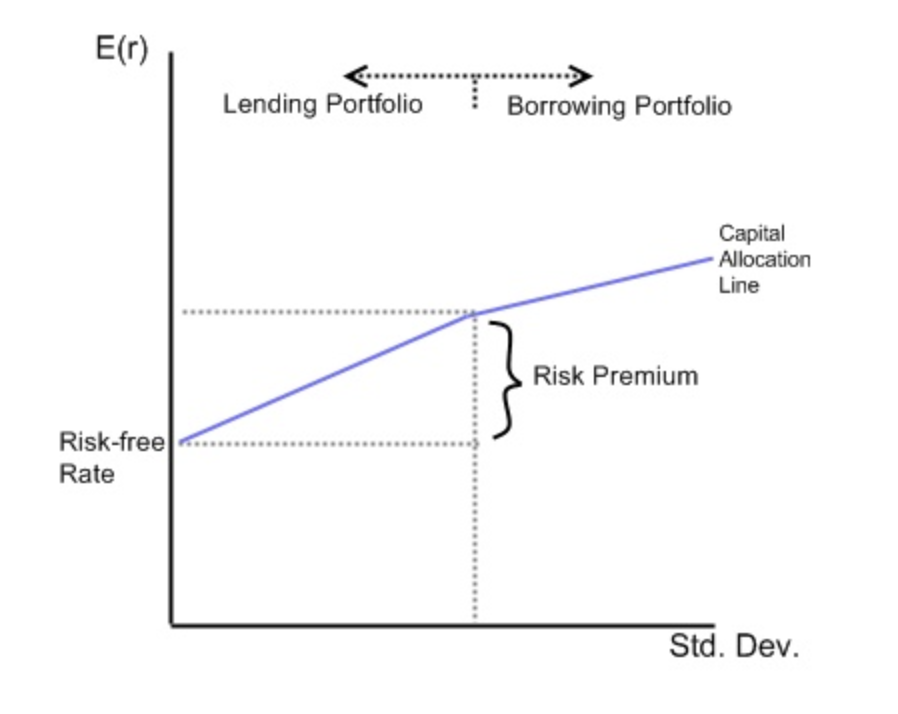
**Capital allocation line**
$$
\mathrm{CAL}: \; E(r_C) = r_F + \sigma_C \frac{E(r_P) - r_F}{\sigma_P}
$$


If investors can purchase a risk free asset with some return $ r_F $, then all correctly priced risky assets or portfolios will have expected return of the form

$$ E(R_P) = r_F + b\,\sigma_P $$

where $\ b $ is some incremental return to offset the risk (sometimes known as a risk premium), and $\sigma_P $ is the risk itself expressed as the standard deviation. By rearranging, we can see the risk premium has the following value:

$$ b = \frac{E(R_P) - r_F}{\sigma_P} $$

Substituting in our derivation for the risk premium above:

$$
E(R_C) = r_F + \sigma_C \frac{E(R_P) - r_F}{\sigma_P}
$$

This yields the Capital Allocation Line.

**Efficient frontier**

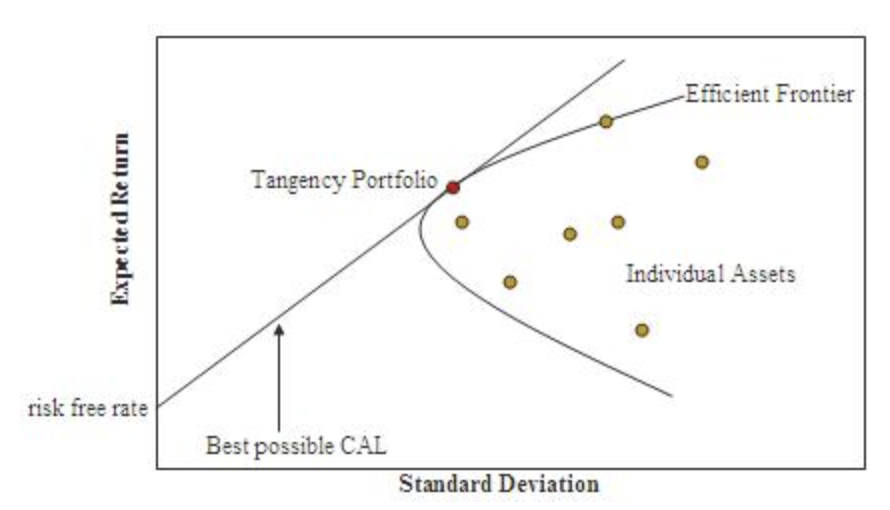

When CAL is tangent to Efficient Frontier, that point is the optimal portfolio, we can know the return and volatility of that portfolio, and the weights of each asset.
### **Tangency (Optimal) Portfolio**

When the Capital Allocation Line (CAL) is tangent to the Efficient Frontier, the tangency portfolio is achieved. This portfolio is optimal in the sense that it offers the highest risk-adjusted return (maximum Sharpe Ratio). At the tangency point, the slope of the CAL represents the Sharpe ratio of the tangency portfolio.

The tangency portfolio weights can be derived from the following formula:

$$
w^* = \frac{\Sigma^{-1}\left(E(r) - r_F\,\mathbf{I}\right)}{\mathbf{I}^T\,\Sigma^{-1}\left(E(r) - r_F\,\mathbf{I}\right)}
$$

Where:
- $ \Sigma $ is the covariance matrix of asset returns,
- $ E(r) $ is the vector of expected asset returns,
- $ r_F $ is the risk-free rate,
- $ \mathbf{I} $ is a vector of ones.

Once the optimal weights $ w^* $ are obtained, the tangency portfolio’s expected return and volatility are given by:

**Expected Return:**
$$
E(r_T) = w^{*T}E(r)
$$
**Volatility:**
$$
\sigma_T = \sqrt{w^{*T}\,\Sigma\,w^*}
$$

The maximum Sharpe ratio (slope of the CAL) is:

$$
\text{Sharpe Ratio} = \frac{E(r_T) - r_F}{\sigma_T}
$$

This tangency portfolio represents the best possible combination of risky assets when a risk-free asset is available. Any portfolio formed as a combination of the risk-free asset and the tangency portfolio will lie on the CAL, offering the optimal risk-return trade-off.

---

**Optimization Problem:**
$$
\max_w \quad w^T \mu - \frac{\gamma}{2} w^T \Sigma w
$$

Where:
- $ w $ = vector of portfolio weights,
- $ \mu $ = vector of expected asset returns,
- $ \Sigma $ = covariance matrix of asset returns,
- $ \gamma $ = risk aversion parameter.

This is the mean-variance optimization problem, where the goal is to maximize the expected return of the portfolio $ w^T \mu $ while penalizing for risk $ \frac{1}{2} w^T \Sigma w $.

**Optimal Weights Calculation:**
$$
w = \frac{1}{\gamma} \Sigma^{-1} \mu
$$

Where:
- $ w $ = optimal portfolio weights,
- $ \Sigma^{-1} $ = inverse of the covariance matrix,
- $ \mu $ = vector of expected returns,
- $ \gamma $ = risk aversion parameter.

The portfolio weights are obtained by solving for the optimal balance between return and risk using the covariance matrix and the expected returns. The risk aversion parameter $ \gamma $ determines how much risk the investor is willing to take in exchange for higher returns.


In [31]:
# 4. Quadratic Programming: GMV, MSR, and Efficient Frontier Calculation

def global_min_var_portfolio(Sigma, short=False):
    """
    No short selling => w_i >= 0
    Objective: minimize w^T Sigma w
    Constraint: sum(w) = 1
    """
    n_ = Sigma.shape[0]
    def objective(w):
        return w @ Sigma @ w
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    if short:
        bounds = None   # Allow short selling
    else:
        bounds = [(0, None)] * n_
    w0 = np.repeat(1/n_, n_)
    res = minimize(objective, w0, method="SLSQP", constraints=cons, bounds=bounds)
    if not res.success:
        raise ValueError("GMV optimization failed: " + res.message)
    return res.x

def msr_portfolio(Sigma, mu, risk_free=0.02, short=False):
    """
    Maximum Sharpe Ratio portfolio (Tangency portfolio)
    Minimize 0.5 * w^T Sigma w
    Subject to: (mu - rf)^T w = 1, and w_i >= 0 (if short=False)
    Finally, normalize to sum(w)=1
    """
    n_ = len(mu)
    excess = mu - risk_free
    def objective(w):
        return 0.5 * w @ Sigma @ w
    cons = [{"type": "eq", "fun": lambda w: w @ excess - 1}]
    if short:
        bounds = None
    else:
        bounds = [(0, None)] * n_
    w0 = np.repeat(1/n_, n_)
    res = minimize(objective, w0, method="SLSQP", constraints=cons, bounds=bounds)
    if not res.success:
        raise ValueError("MSR optimization failed: " + res.message)
    w_raw = res.x
    w_norm = w_raw / np.sum(w_raw)
    return w_norm

def min_var_given_return(mu, Sigma, target_return, short=False):
    """
    Given a target return, find the minimum variance portfolio
    Constraints: sum(w)=1, mu^T w = target_return, and w_i >= 0 (if short=False)
    """
    n_ = len(mu)
    def objective(w):
        return w @ Sigma @ w
    cons = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - target_return}
    ]
    if short:
        bounds = None
    else:
        bounds = [(0, None)] * n_
    w0 = np.repeat(1/n_, n_)
    res = minimize(objective, w0, method="SLSQP", constraints=cons, bounds=bounds)
    if not res.success:
        return None, None, None
    w_opt = res.x
    var_ = w_opt @ Sigma @ w_opt
    ret_ = w_opt @ mu
    return w_opt, np.sqrt(var_), ret_

def compute_efficient_frontier(mu, Sigma, short=False, points=50):
    """
    Uniformly take several target return points in the interval [min(mu), max(mu)]
    and find the minimum variance portfolio for each, forming a continuous frontier.
    Returns a DataFrame: [Volatility, Returns, Weights]
    """
    min_ret = mu.min()
    max_ret = mu.max()
    frontier_data = []
    for target in np.linspace(min_ret, max_ret, points):
        w_opt, vol_, ret_ = min_var_given_return(mu, Sigma, target, short=short)
        if w_opt is not None:
            frontier_data.append((vol_, ret_, w_opt))
    frontier_data.sort(key=lambda x: x[0])
    df_front = pd.DataFrame(frontier_data, columns=["Volatility", "Returns", "Weights"])
    return df_front

In [33]:
# 5. Calculate GMV and MSR and store in StockReturns
mu_train = stock_return.mean() * 252  # Annual return estimate from training 
mu_np = mu_train.values
Sigma_np = cov_mat_annual.values

# GMV
gmv_weights = global_min_var_portfolio(Sigma_np, short=False)
GMV_weights_df = pd.DataFrame({"Code": code_list, "Weight": gmv_weights})
StockReturns["GMV"] = test_daily_return.mul(gmv_weights, axis=1).sum(axis=1)

# MSR
msr_weights = msr_portfolio(Sigma_np, mu_np, risk_free=risk_free, short=False)
MSR_weights_df = pd.DataFrame({"Code": code_list, "Weight": msr_weights})
StockReturns["MSR"] = test_daily_return.mul(msr_weights, axis=1).sum(axis=1)



In [35]:
StockReturns["GMV"]

date
2020-01-02    0.006192
2020-01-03    0.011250
2020-01-06    0.041869
2020-01-07   -0.016044
2020-01-08    0.015892
                ...   
2023-12-25    0.010768
2023-12-26    0.007264
2023-12-27    0.017310
2023-12-28   -0.004294
2023-12-29   -0.000452
Name: GMV, Length: 970, dtype: float64

In [37]:
StockReturns["MSR"] 

date
2020-01-02    0.005222
2020-01-03    0.009356
2020-01-06   -0.011853
2020-01-07    0.004408
2020-01-08    0.001392
                ...   
2023-12-25   -0.008977
2023-12-26   -0.008516
2023-12-27    0.001738
2023-12-28    0.055176
2023-12-29   -0.009119
Name: MSR, Length: 970, dtype: float64

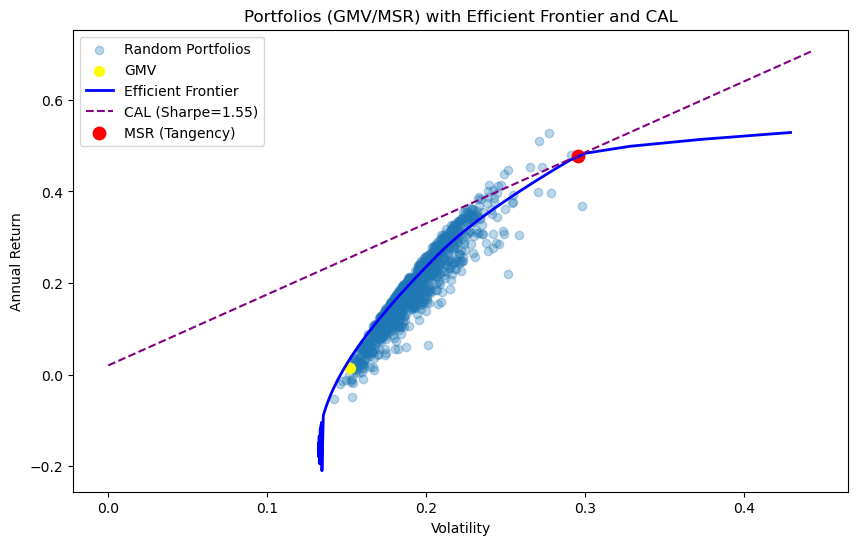

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already computed necessary variables:
# RandomPortfolios, positive_returns, mu_np, Sigma_np, risk_free, min_positive_index, max_positive_index
# These are all part of your portfolio optimization process

# Plot GMV, MSR with CAL and Efficient Frontier

def scatter_plot():
    strategies = ["GMV", "MSR"]  # Specify your chosen strategies here
    plt.figure(figsize=(10, 6))
    
    # 1) Random portfolios scatter
    plt.scatter(RandomPortfolios["Volatility"], RandomPortfolios["Returns"], alpha=0.3, label="Random Portfolios")

    # 2) If GMV is selected, mark the minimum volatility portfolio from random portfolios (for reference)
    if "GMV" in strategies and not positive_returns.empty:
        x_gmv = RandomPortfolios.loc[min_positive_index, "Volatility"]
        y_gmv = RandomPortfolios.loc[min_positive_index, "Returns"]
        plt.scatter(x_gmv, y_gmv, color="yellow", s=50, label="GMV")

    # 3) If Max Variance is selected, mark the maximum volatility portfolio from random portfolios
    if "MSR" in strategies and not positive_returns.empty:
        x_msr = RandomPortfolios.loc[max_positive_index, "Volatility"]
        y_msr = RandomPortfolios.loc[max_positive_index, "Returns"]
       

    # 4) Compute and plot the "true" efficient frontier via quadratic programming
    frontier_df = compute_efficient_frontier(mu_np, Sigma_np, short=False, points=50)
    plt.plot(frontier_df["Volatility"], frontier_df["Returns"], color="blue", lw=2, label="Efficient Frontier")

    # 5) Plot MSR (tangency portfolio) + CAL
    msr_ret = msr_weights @ mu_np
    msr_vol = np.sqrt(msr_weights @ Sigma_np @ msr_weights)
    sharpe_ratio = (msr_ret - risk_free) / msr_vol
    
    # Plot CAL (from 0 to 1.5 times MSR volatility)
    cal_x = np.linspace(0, msr_vol * 1.5, 50)
    cal_y = risk_free + sharpe_ratio * cal_x
    plt.plot(cal_x, cal_y, "--", color="purple", label=f"CAL (Sharpe={sharpe_ratio:.2f})")

    # If MSR is selected, mark the MSR point
    if "MSR" in strategies:
        plt.scatter(msr_vol, msr_ret, color="red", s=80, label="MSR (Tangency)")

    plt.xlabel("Volatility")
    plt.ylabel("Annual Return")
    plt.title("Portfolios (GMV/MSR) with Efficient Frontier and CAL")
    plt.legend()
    plt.show()

# Call the function to plot
scatter_plot()


In [41]:
# 6. Prepare Cumulative Returns
def get_cum_ret(daily_ret_series):
    total_amount = initial_amount
    acc = [total_amount]
    for r in daily_ret_series:
        total_amount = total_amount * r + total_amount
        acc.append(total_amount)
    return acc


In [43]:
# Extract required series
cum_ret_marketcap = get_cum_ret(StockReturns["marketcap weighted"])
cum_ret_equal = get_cum_ret(StockReturns["equal weight"])
cum_ret_gmv = get_cum_ret(StockReturns["GMV"])
cum_ret_msr = get_cum_ret(StockReturns["MSR"])

# Performance comparison

In [46]:
from metric import *
ss_daily = summary_stats(StockReturns, riskFree=risk_free, periodsInYear=252)
print(ss_daily)


                           marketcap weighted equal weight Max Variance  \
Annualized Returns                      6.28%        4.23%       -9.27%   
Annualized Volatility                  25.10%       22.46%       35.16%   
Sharpe Ratio                             0.17         0.10        -0.31   
Sortino Ratio                            0.24         0.13        -0.37   
Max Drawdown                          -30.41%      -33.21%      -62.85%   
Skewness                                -0.61        -0.79        -1.62   
Kurtosis                                 8.65         7.13        14.92   
Cornish Fisher adj. VAR 5%              2.64%        2.48%        4.03%   

                                GMV      MSR  
Annualized Returns            3.67%    1.00%  
Annualized Volatility        25.61%   41.92%  
Sharpe Ratio                   0.06    -0.02  
Sortino Ratio                  0.10    -0.03  
Max Drawdown                -31.93%  -71.76%  
Skewness                       0.26    -0.

- **Best Strategy in Terms of Risk-Adjusted Returns**: The Market Cap Weighted strategy, while it has a moderate return, has the best Sharpe and Sortino ratios, indicating the most favorable risk-return trade-off.
- **Worst Strategy in Terms of Risk-Adjusted Returns**: The Maximum Sharpe Ratio (MSR) strategy performs the worst in terms of returns and risk-adjusted returns, with a negative Sharpe ratio and extremely high volatility.
- **Stability**: The Market Cap Weighted and Global Minimum Variance strategies have relatively moderate volatility, while the Maximum Variance and MSR strategies exhibit extreme volatility and poor risk management.
- **Long-Term Risk**: The Maximum Variance strategy and the MSR strategy are the riskiest, with massive potential drawdowns and poor risk-adjusted returns. The Equal Weight and GMV strategies show better stability but at the cost of lower returns.

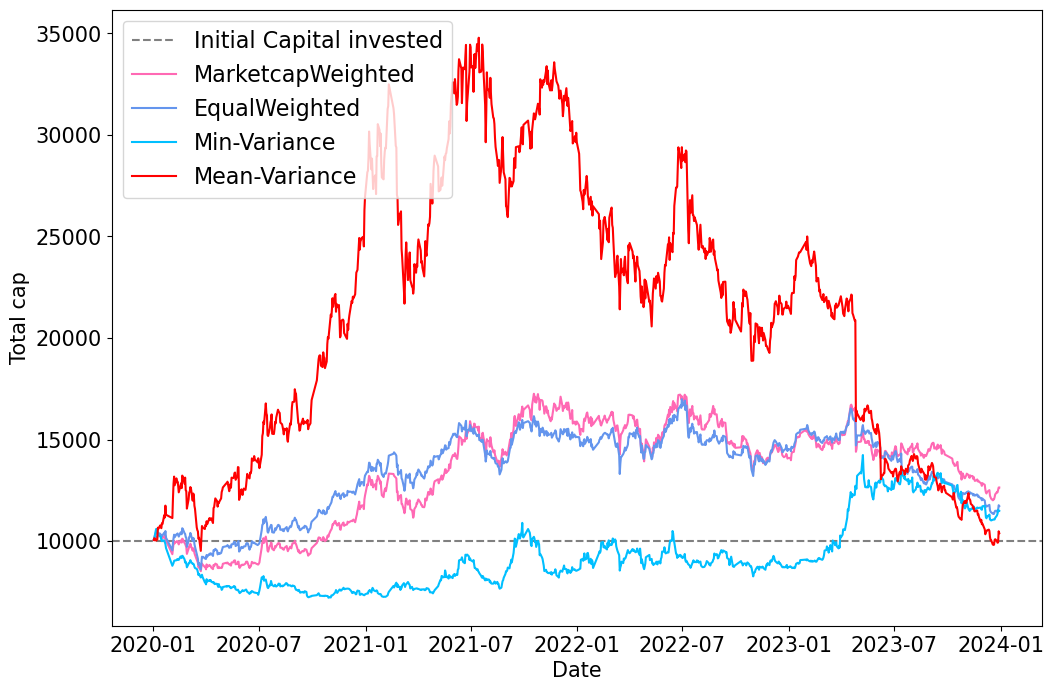

In [49]:
initial_amount=10000
def get_cum_ret(daily_return):
    
    total_amount=initial_amount
    account_growth=list()
    account_growth.append(initial_amount)
    for i in range(len(daily_return)):
        total_amount = total_amount * daily_return.iloc[i] + total_amount
        account_growth.append(total_amount)
    return account_growth

daily_return1=StockReturns['marketcap weighted']
daily_return2=StockReturns['equal weight']
daily_return3=StockReturns['GMV']
daily_return4=StockReturns['MSR']
cum_ret1 = get_cum_ret(daily_return1)
cum_ret2 = get_cum_ret(daily_return2)
cum_ret3 = get_cum_ret(daily_return3)
cum_ret4 = get_cum_ret(daily_return4)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15}) 
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

plt.figure(figsize=(12, 8))
plt.axhline(y=initial_amount, linestyle="--", color="grey", label="Initial Capital invested")
plt.plot(StockReturns.index, cum_ret1[1:],color="hotpink",label="MarketcapWeighted")
plt.plot(StockReturns.index, cum_ret2[1:],color="cornflowerblue",label="EqualWeighted")
plt.plot(StockReturns.index, cum_ret3[1:],color="deepskyblue",label="Min-Variance")
plt.plot(StockReturns.index, cum_ret4[1:],color="red",label="Mean-Variance")
plt.xlabel("Date")
plt.ylabel("Total cap")
plt.legend(loc='upper left',fontsize=16)
plt.show()
plt.close()

# Summary of the result

**1. Short-term Performance (2020-2021)**:
Market Cap Weighted (Pink): This strategy sees moderate growth in the early part of the period, but its performance is relatively volatile, with fluctuations showing both sharp increases and decreases.
Equal Weighted (Blue): The equal weight strategy experiences more stability compared to the market cap weighted strategy. Its growth rate is somewhat steady, but it does not perform as well as others in the short term.
Min-Variance (Light Blue): The Min-Variance portfolio has the least growth in the early period. It shows relatively small fluctuations, implying it prioritizes risk minimization over returns.
Mean-Variance (Red): This strategy performs the best in the short term, with significant upward growth. It seems to take more risk but offers higher rewards compared to the other strategies.
**2. Long-term Performance (2021-2024)**:
Market Cap Weighted (Pink): This strategy suffers in the long term, with a sharp decline after peaking, which shows a loss after a period of strong growth. It seems to be highly affected by market downturns.
Equal Weighted (Blue): The equal-weighted strategy does not experience extreme fluctuations but instead sees moderate gains. Its performance is steadier, especially after the 2021 peak.
Min-Variance (Light Blue): Similar to the Equal-weighted strategy, the Min-Variance portfolio continues to perform with less volatility. However, it grows slowly and remains one of the more stable strategies throughout.
Mean-Variance (Red): In the long term, the Mean-Variance strategy, despite a major dip, shows recovery and maintains the highest growth trajectory. This implies it may have experienced larger volatility during market crashes, but it is ultimately more rewarding over time.

Conclusion:
Short-term: Mean-Variance performs the best, offering high returns, though with some risk. Market Cap Weighted exhibits higher volatility, while Min-Variance and Equal Weighted strategies are more stable but less profitable in the short run.
Long-term: Mean-Variance remains the best performer with the most growth potential, even though it shows higher volatility. Min-Variance and Equal Weighted strategies maintain steady but slower growth. Market Cap Weighted struggles significantly, facing a large decline after peaking.


**Table: Comparasion between different portfolio strategies**

| **Strategy**              | **Covariance Usage** | **Optimization** | **Pros**                                                                | **Cons**                                                                                      |
|---------------------------|------------------------|-------------------|-------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **Equal Weights (1/N)**   | No                    | No                | - Very simple<br>- Robust<br>- Good benchmark                           | - Ignores volatility/correlation<br>- Doesn’t adapt to changing market conditions             |                 |
| **Mean-Variance (MV)**    | Yes                   | Yes               | - Classic Markowitz approach<br>- Potential for better risk-return tradeoff | - Can produce extreme weights if estimates are off<br>- Requires stable input estimates       |
| **Minimum Variance** (subset of MV)      | Yes                   | Yes| - Specifically minimizes overall variance<br>- Lower overall risk        | - May ignore expected returns<br>- Often concentrates in low-vol assets                       |
| **Maximum Variance** (subset of MV)     | Yes                   | Yes| - Theoretical opposite extreme<br>- Explores full risk spectrum          | - Extremely high risk, rarely used<br>- Often invests heavily in high-vol assets              |
| **Market Value Weighted** | No                    | No                | - Reflects real market proportions<br>- Widely used (e.g., S&P 500 index) | - Concentrates in largest stocks<br>- Ignores risk/correlation directly                       |

# Reference

Victor DeMiguel, Lorenzo Garlappi, Raman Uppal, Optimal Versus Naive Diversification: How Inefficient is the 1/N Portfolio Strategy?, The Review of Financial Studies, Volume 22, Issue 5, May 2009, Pages 1915–1953, https://doi.org/10.1093/rfs/hhm075


https://sites.math.washington.edu/~burke/crs/408/fin-proj/mark1.pdf

http://en.wikipedia.org/wiki/Capital_allocation_line

https://en.wikipedia.org/wiki/Efficient_frontier

The metrics I learned from this online course
Portfolio management with Python : EDHEC Buesness school URL: https://www.coursera.org/specializations/investment-management-python-machine-learning#courses

and their GitHub storage: 
URL: https://github.com/PeterSchuld/EDHEC_Investment-Management-with-Python-and-Machine-Learning-

mainly from MOOC1
URL: https://github.com/PeterSchuld/EDHEC_Investment-Management-with-Python-and-Machine-Learning-/blob/main/MOOC1_Introduction%20to%20Portfolio%20Construction/edhec_risk_kit_104.py

URL: https://github.com/PeterSchuld/EDHEC_Investment-Management-with-Python-and-Machine-Learning-/blob/main/MOOC1_Introduction%20to%20Portfolio%20Construction/edhec_risk_kit_105.py

Also I refered to other authors' work:
The general navigation page : 

URL: https://github.com/topics/portfolio-optimization

URL: https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb

Min-variance: https://zhuanlan.zhihu.com/p/658168978